# Tutorial 5 - Adaptive PIKANs

In Tutorial 3 we got a taste of solving PDEs using KANs and in Tutorial 4 we started exploring adaptive training techniques. Blending these two together, in this tutorial we will see how to adaptively train PIKANs, based on the findings of [this](https://ieeexplore.ieee.org/document/10763509) paper.

In [1]:
from jaxkan.KAN import KAN

import jax
import jax.numpy as jnp

from jaxkan.utils.PIKAN import sobol_sample, gradf, get_adaptive_loss
from jaxkan.utils.general import adam_transition

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

## Data Generation

Burgers' Equation was relatively easy to solve even without adaptive techniques, so in this case we will be solving the Allen-Cahn Equation,

$$ \frac{\partial u}{\partial t} - D\frac{\partial^2 u}{\partial x^2} + 5 \left(u^3 - u\right) = 0,$$

for $D = 10^{-3}$ in the $\Omega = [0,1]\times [-1, 1]$ domain, subject to the boundary conditions

$$ u\left(t=0, x\right) = x^2 \cos\left(\pi x\right), $$

$$ u\left(t, x=-1\right) = u\left(t, x=1\right) = -1. $$

In the following, we must first define the corresponding collocation points, again using Sobol sampling.

In [2]:
seed = 42

# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), N, seed)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([0,1]), N, seed)) # (64, 2)
BC1_data = ((BC1_colloc[:,1]**2)*jnp.cos(jnp.pi*BC1_colloc[:,1])).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,-1]), N, seed)) # (64, 2)
BC2_data = -jnp.ones(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N, seed)) # (64, 2)
BC3_data = -jnp.ones(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

## KAN Model

We covered KAN Model selection in the first tutorial, so feel free to refer to it for more info. For this example, we will be using the `spline` KAN Layer.

In [3]:
# Initialize a KAN model
n_in = collocs.shape[1]
n_out = 1
n_hidden = 8

layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'k': 4, 'G': 3, 'grid_e': 0.02}

model = KAN(layer_dims = layer_dims,
            layer_type = 'spline',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )


## Adaptive Training

Now all we need to do is simply define the PDE loss for this problem.

In [4]:
# PDE Loss
def pde_loss(model, collocs):
    # Eq. parameter
    D = jnp.array(0.001, dtype=float)
    c = jnp.array(5.0, dtype=float)

    def u(x):
        y = model(x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)
    u_xx = gradf(u, 1, 2)
    
    # Residual
    pde_res = u_t(collocs) - D*u_xx(collocs) - c*(u(collocs)-(u(collocs)**3))
    
    return pde_res

The selected model instance will be trained for a total of $5\cdot 10^4$ epochs, using a series of different adaptive techniques. First of all, the learning rate will be modified throughout training.

In [5]:
# Training epochs
num_epochs = 50000

# Define scheduler learning rates
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0, 15_000 : 0.6, 25_000 : 0.8}

# Setup scheduler for optimizer
scheduler = optax.piecewise_constant_schedule(
    init_value=lr_vals['init_lr'],
    boundaries_and_scales=lr_vals['scales']
)

# We will also use the Nesterov version of Adam
opt_type = optax.adam(learning_rate=scheduler, nesterov=True)

# Define the optimizer
optimizer = nnx.Optimizer(model, opt_type)

Throughout training, apart from grid updates, i.e. a combination of extending the grid and subsequently adapting it on the data, we may perform grid adaptations alone.

In [6]:
# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3, 5000 : 8, 20_000 : 12}

# Define epochs for grid adaptation - in this case we opt not to
grid_adapt = []

In cases where domain expertise is available, one may choose to scale each term of the total loss function in a way that justifies prioritizing a certain boundary condition, or the PDE loss, etc. For this purpose, one may define global weights, although in this example they are all set equal to one. Additionally, one may also define local weights, for the purposes of the RBA technique (more information can be found in the paper mentioned at the start of the tutorial).

In [7]:
# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

# Initialize RBA weights
loc_w = [jnp.ones((collocs.shape[0],1)), jnp.ones((BC1_colloc.shape[0],1)),
         jnp.ones((BC2_colloc.shape[0],1)), jnp.ones((BC3_colloc.shape[0],1))]

Depending on if the user chooses to define local weights or not, they have to use either the `vanilla` or the `adaptive` version of the loss function, by calling the `get_vanilla_loss` or the `get_adaptive_loss` method, respectively. 

In [8]:
# Define loss function, depending on if the user wants to use RBA weights or not
if loc_w is None:
    loss_fn = get_vanilla_loss(pde_loss, model)
else:
    loss_fn = get_adaptive_loss(pde_loss, model)

Note that even if they do not use RBA weights and therefore choose the vanilla loss, they may still train a PIKAN adaptively by implementing other techniques. One such technique is the adaptive re-sampling of collocation points.

In [9]:
# Perform adaptive collocation point sampling
colloc_adapt = {'lower_point' : np.array([0,-1]), 'upper_point' : np.array([1,1]),
                'M' : 2**16, 'k' : jnp.array(1.0, dtype=float), 'c' : jnp.array(1.0, dtype=float),
                'epochs' : [10_000, 20_000]}

if colloc_adapt['epochs']:
    # Define the function
    def resample_collocs(model, collocs, sample, k=jnp.array(1.0), c=jnp.array(1.0)):
        # Calculate residuals of PDE
        resids = jnp.abs(pde_loss(model, sample))
        # Raise to power k
        ek = jnp.power(resids, k)
        # Divide by mean and add c
        px = (ek/jnp.mean(ek)) + c
        # Normalize
        px_norm = (px / jnp.sum(px))[:,0]
        # Draw ids for the sampled points using px_norm
        X_ids = jax.random.choice(key=jax.random.PRNGKey(0), a=sample.shape[0], shape=(collocs.shape[0],), replace=False, p=px_norm)
        # Replace collocation points
        new_collocs = sample[X_ids]
    
        return new_collocs

    # Sample M points from Sobol
    M = colloc_adapt['M']
    lp = colloc_adapt['lower_point']
    up = colloc_adapt['upper_point']
    sample = jnp.array(sobol_sample(lp, up, M))
    # Draw k, c hyperparameters
    k, c = colloc_adapt['k'], colloc_adapt['c']

Based on these, we may start training the adaptive PIKAN to solve the Allen-Cahn Equation.

In [10]:
@nnx.jit
def train_step(model, optimizer, collocs, bc_collocs, bc_data, glob_w, loc_w):
    
    (loss, loc_w), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, collocs, bc_collocs, bc_data, glob_w, loc_w)
    optimizer.update(grads)

    return loss, loc_w

In [11]:
train_losses = jnp.zeros((num_epochs,))
adapt_state = True

# Start training
update_val = grid_extend[0]
for epoch in range(num_epochs):
    if epoch in colloc_adapt['epochs']:
        # Get new colloc points
        collocs = resample_collocs(model, collocs, sample, k, c)

        # Restart training loc_w for the PDE if we're doing RBA
        if loc_w is not None:
            new_loc_w = jnp.full_like(loc_w[0], jnp.mean(loc_w[0]))
            loc_w[0] = new_loc_w

        # A grid adaptation is necessary for base/spline after resampling
        if model.layer_type in ['base', 'spline']:
            G = model.layers[0].grid.G
            model.update_grids(collocs, G)

    # Check if we're in an adapt epoch - this pertains only to base/spline layers
    if (epoch in grid_adapt) and (model.layer_type in ['base', 'spline']):
        model.update_grids(collocs, update_val)

    # Check if we're in an extension epoch
    if epoch in grid_extend.keys():
        # If the layer is not base/spline type, then there should be no update on epoch 0
        if (model.layer_type not in ['base', 'spline']) and (epoch == 0):
            pass
        else:
            print(f"Epoch {epoch}: Performing grid update")
            # Get grid size
            update_val = grid_extend[epoch]
            # Perform the update
            model.update_grids(collocs, update_val)
    
            # Optimizer Transition - necessary only for epochs =/= 0, where there is actual extension
            if adapt_state and (epoch != 0):
                _, model_state = nnx.split(model)
                old_state = optimizer.opt_state
                adam_transition(old_state, model_state)
            else:
                optimizer = nnx.Optimizer(model, opt_type)
        

    loss, loc_w = train_step(model, optimizer, collocs, bc_collocs, bc_data, glob_w, loc_w)
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

Epoch 0: Performing grid update
Epoch 5000: Performing grid update
Epoch 20000: Performing grid update


All of the above have been neatly incorporated into the `train_PIKAN` method of `jaxkan.utils.PIKAN` module, so adaptively training a PIKAN is as simple as calling the function with the proper arguments, as follows:

```python
from jaxkan.utils.PIKAN import train_PIKAN

num_epochs = 50000

lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0, 15_000 : 0.6, 25_000 : 0.8}

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3, 5000 : 8, 20_000 : 12}

# Define epochs for grid adaptation - in this case we opt not to
grid_adapt = []

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

# Initialize RBA weights
loc_w = [jnp.ones((collocs.shape[0],1)), jnp.ones((BC1_colloc.shape[0],1)),
         jnp.ones((BC2_colloc.shape[0],1)), jnp.ones((BC3_colloc.shape[0],1))]

# Perform adaptive collocation point sampling
colloc_adapt = {'lower_point' : np.array([0,-1]), 'upper_point' : np.array([1,1]),
                'M' : 2**16, 'k' : jnp.array(1.0, dtype=float), 'c' : jnp.array(1.0, dtype=float),
                'epochs' : [10_000, 20_000]}

model, train_losses = train_PIKAN(model, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                  lr_vals=lr_vals, collect_loss=True, adapt_state=True, loc_w=loc_w,
                                  nesterov=True, num_epochs=num_epochs, grid_extend=grid_extend,
                                  grid_adapt=grid_adapt, colloc_adapt=colloc_adapt)
```

## Evaluation

By visualizing the train loss curve, we indeed see how the adaptive training techniques implemented lead to a significantly small training error by the end of training.

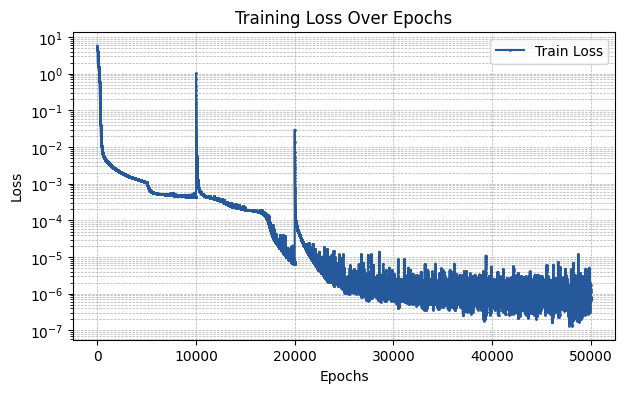

In [12]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

Additionally, we observe a good approximation to the actual solution to the Allen-Cahn equation, which cannot be obtained without utilizing any adaptive technique.

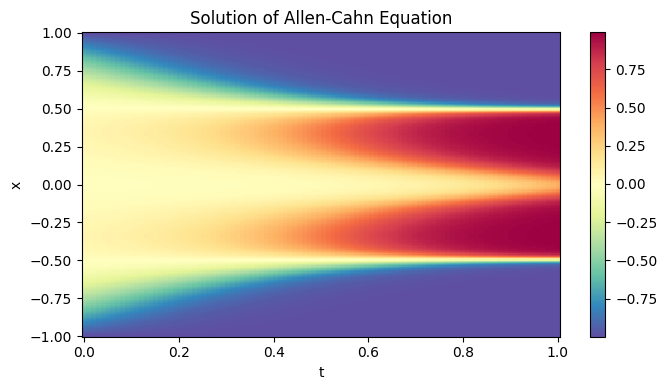

In [13]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Allen-Cahn Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()